In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

<div style="padding: 6px 12px 18px 12px; background: #eeffee; border: 2px solid #88aa88; border-radius: 4px;">

<h2>Preface: Installing Devito (do not include in manuscipt)</h2>

<p>This tutorial and the coming second part are based on Devito version 3.1.0. It requires the installation of the full software with examples, not only the code generation API. To install:</p>

<pre style="background: #eeffee;">
  git clone -b v3.1.0 https://github.com/opesci/devito
  cd devito
  conda env create -f environment.yml
  source activate devito
  pip install -e .
</pre>

<p>That final dot is important, don't miss it out!</p>

<h3>Useful links</h3>

<ul>
<li><a href="http://www.opesci.org/">Devito documentation</a></li>
<li><a href="https://github.com/opesci/Devito">Devito source code and examples</a></li>
<li><a href="https://github.com/opesci/Devito/examples/seismic/tutorials">Tutorial notebooks with latest Devito/master</a></li>
</ul>

</div>

### Geophysics tutorial


# Full-Waveform Inversion - Part 2: adjoint modeling

Mathias Louboutin<sup>1</sup>\*, Philipp Witte<sup>1</sup>, Michael Lange<sup>2</sup>, Navjot Kukreja<sup>2</sup>, Fabio Luporini<sup>2</sup>, Gerard Gorman<sup>2</sup>, and Felix J. Herrmann<sup>1,3</sup>

<sup>1</sup> Seismic Laboratory for Imaging and Modeling (SLIM), The University of British Columbia 

<sup>2</sup> Imperial College London, London, UK

<sup>3</sup> now at Georgia Institute of Technology, USA 

Corresponding author: mloubout@eoas.ubc.ca


## Introduction

This tutorial is the second part of a three part tutorial series on full-waveform inversion (FWI), in which we provide a step by step walk through of setting up forward and adjoint wave equation solvers and an optimization framework for inversion. In part 1 (Louboutin et al., 2017), we demonstrated how to discretize the acoustic wave equation and how to set up a basic forward modeling scheme using [Devito], a domain-specific language (DSL) in Python for automated finite-difference (FD) computations (Lange et al., 2016). [Devito] allows us to define wave equations as symbolic Python expressions (Meurer et al., 2017), from which optimized FD stencil code is automatically generated at run time. In part 1, we show how we can use [Devito] to set up and solve acoustic wave equations with (impulsive) seismic sources and sample wavefields at the receiver locations to model shot records.

[Devito]:http://www.opesci.org/devito-public

In the second part of this tutorial series, we will discuss how to set up and solve adjoint wave equations with [Devito] and from that, how we can calculate gradients and function values of the FWI objective function. The gradient of FWI is most commonly computed via the adjoint state method, by cross-correlating forward and adjoint wavefields and summing the contributions over all time steps (refer to Plessix (2006) in the context of seismic inversion). Calculating the gradient for one source location consists of three steps:

* Solve the forward wave equation to create a shot record. The time varying wavefield must be stored for use in step 3; techniques such as subsampling can be used to reduce the storage requirements.

* Compute the data residual (or data misfit) between the predicted and observed data.

* Solve the corresponding discrete adjoint model using the data residual as the source. Within the adjoint (reverse) time loop, cross correlate the second time derivative of the adjoint wavefield with the forward wavefield. These cross correlations are summed to form the gradient.

We start with the definition and derivation of the adjoint wave equation and its [Devito] stencil and then show how to compute the gradient of the conventional least squares FWI misfit function. We demonstrate the gradient computation on a simple 2D model and introduce a verification framework for unit testing. Furthermore, we provide a simple FWI gradient descent example, which can be found in the notebook **`adjoint_modeling.ipynb`**. As usual, this tutorial is accompanied by all the code you need to reproduce the figures. Go to  github.com/seg/tutorials-2017 and follow the links.

## The adjoint wave equation

Adjoint wave equations are a main component in seismic inversion algorithms and are required for computing gradients of both linear and non-linear objective functions. To ensure stability of the adjoint modeling scheme and the expected convergence of inversion algorithms, it is very important that the adjoint wave equation is in fact the adjoint (transpose) of the forward wave equation. The derivation of the adjoint wave equation in the acoustic case is simple, as it is self-adjoint if we ignore the absorbing boundaries for the moment. However, in the general case, discrete wave equations do not have this property (such as the coupled anisotropic TTI wave equation (Zhang et al., 2011)) and require correct derivations of their adjoints. We concentrate here, as in part 1, on the acoustic case and follow an optimize-discretize approach, which means we write out the adjoint wave equation for the continuous case first and then discretize it, using finite difference operators of the same order as for the forward equation. With the variables defined as in part 1 and the data residual $\delta d(x,y,t; x_r, y_r)$, located at $x_r, y_r$ {++(receivers locations)++}, as the adjoint source, the continuous adjoint wave equation is given by:

$$
 m(x,y) \frac{d^2 v(t,x,y)}{dt^2} - \nabla^2 v(t,x,y) - \eta(x,y) \frac{d v(t,x,y)}{dt}=\delta d(t,x,y;x_r, y_r)
$${#WEa}

Since the acoustic wave equation contains only second spatial and temporal derivatives, which are both self-adjoint, the adjoint acoustic wave equation is equivalent to the forward equation with the exception of the damping term $\eta(x,y) \frac{d v(t,x,y)}{dt}$, which contains a first time derivative and therefore has a change of sign in its adjoint. A second derivative matrix is the same as its transpose, whereas a first derivative matrix is equal to its negative transpose and vice versa.

Following part 1, we first define the discrete adjoint wavefield $\mathbf{v}$ as a [Devito] `TimeFunction` object and then symbolically set up the PDE and rearrange the expression:

In [2]:
# NOT FOR MANUSCRIPT
from examples.seismic import demo_model, plot_velocity, plot_perturbation

shape = (101, 101)  # Number of grid point (nx, nz)
spacing = (10., 10.)  # Grid spacing in m. The domain size is now 1km by 1km
origin = (0., 0.)  # Need origin to define relative source and receiver locations

model = demo_model('circle-isotropic',
                   vp=3.0,
                   vp_background=2.5,
                   origin=origin,
                   shape=shape,
                   spacing=spacing,
                   nbpml=40)

# For the manuscript, we'll re-form the model using the Vp field from
# this newly created model.
vp = model.vp

model0 = demo_model('circle-isotropic',
                    vp=2.5,
                    vp_background=2.5,
                    origin=origin,
                    shape=shape,
                    spacing=spacing,
                    nbpml=40)

t0 = 0.     # Simulation starts a t=0
tn = 1000.  # Simulation last 1 second (1000 ms)
dt = model.critical_dt  # Time step from model grid spacing

nt = int(1 + (tn-t0) / dt)  # Discrete time axis length
time = np.linspace(t0, tn, nt)  # Discrete modelling time

from devito import Eq
from sympy import solve

In [8]:
from examples.seismic import Model

model = Model(vp=vp,             # A velocity model.
              origin=(0, 0),     # Top left corner.
              shape=(101, 101),  # Number of grid points.
              spacing=(10, 10),  # Grid spacing in m.
              nbpml=40)          # boundary layer.

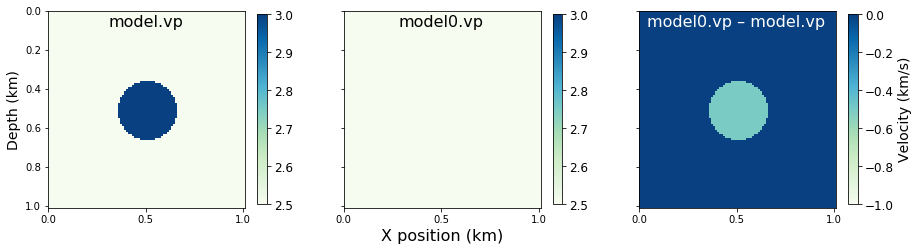

In [9]:
# NOT FOR MANUSCRIPT
fig = plt.figure(figsize=(15, 5))

times = [200, 300, 400]

extent = [model.origin[0], model.origin[0] + 1e-3 * model.shape[0] * model.spacing[0],
          model.origin[1] + 1e-3*model.shape[1] * model.spacing[1], model.origin[1]]

model_param = dict(vmin=2.5, vmax=3.0, cmap="GnBu", aspect=1, extent=extent)
diff_param  = dict(vmin=-1, vmax=0, cmap="GnBu", aspect=1, extent=extent)

ax0 = fig.add_subplot(131)
im = plt.imshow(np.transpose(model.vp), **model_param)
cb = plt.colorbar(im, shrink=0.7)
ax0.set_ylabel('Depth (km)',  fontsize=14)
ax0.text(0.5, 0.08, "model.vp", ha="center", color='k')
#cb.set_label('Velocity (km/s)', fontsize=14)
cb.ax.tick_params(labelsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

ax1 = fig.add_subplot(132)
im = plt.imshow(np.transpose(model0.vp), **model_param)
cb = plt.colorbar(im, shrink=0.7)
ax1.set_xlabel('X position (km)',  fontsize=16)
ax1.set_yticklabels([])
ax1.text(0.5, 0.08, "model0.vp", ha="center", color='k')
#cb.set_label('Velocity (km/s)', fontsize=14)
cb.ax.tick_params(labelsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

ax2 = fig.add_subplot(133)
im = plt.imshow(np.transpose(model0.vp - model.vp), **diff_param)
cb = plt.colorbar(im, shrink=0.7)
ax2.set_yticklabels([])
ax2.text(0.5, 0.08, "model0.vp – model.vp", ha="center", color='w')
cb.set_label('Velocity (km/s)', fontsize=14)
cb.ax.tick_params(labelsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# plt.savefig("../Figures/snaps.pdf")
# plt.savefig("../Figures/snaps.png", dpi=400)
plt.show()

In [10]:
from devito import TimeFunction
v = TimeFunction(name="v", grid=model.grid,
                 time_order=2, space_order=2)

Define adjoint wave equation and rearrange expression:

In [11]:
pde = model.m * v.dt2 - v.laplace - model.damp * v.dt

As before, we then define a stencil:

In [12]:
stencil_v = Eq(v.backward, solve(pde, v.backward)[0])

Just as for the forward wave equation, `stencil_v` defines the update for the adjoint wavefield of a single time step. The only difference is that, while the forward modeling propagator goes forward in time, the adjoint propagator goes backwards in time, since the initial time conditions for the forward propagator turn into final time conditions for the adjoint propagator. As for the forward stencil, we can write out the corresponding discrete expression for the update of the adjoint wavefield:

$$
\mathbf{v}[\text{time}-dt] = 2\mathbf{v}[\text{time}] - \mathbf{v}[\text{time}+dt] + \frac{dt^2}{\mathbf{m}}\Delta \mathbf{v}[\text{time}], \quad \text{time} = n_{t-1} \cdots 1
$${#WEdisadj}

with ``dt`` being the time stepping interval. Once again, this expression does not contain any (adjoint) source terms so far, which will be defined as a separate `SparseFunction` object. Since the source term for the adjoint wave equation is the difference between an observed and modeled shot record, we first define an (empty) shot record `rec` with ``101`` receivers and coordinates defined in `rec_coords`. We then set the data field `rec.data` of our shot record to be the data residual between the observed data `d_obs` and the predicted data `d_pred`. The symbolic source expression `src_term` for our adjoint wave equation is then obtained by *injecting* the data residual into the modeling scheme (`rec.inject`). Since we solve the time-stepping loop backwards in time, the `src_term` is used to update the previous adjoint wavefield `v.backward`, rather than the next wavefield. As in the forward modeling example, the source is scaled by  $\frac{dt^2}{\mathbf{m}}$. In Python, we have

In [13]:
# NOT FOR MANUSCRIPT
nshots = 21  # Number of shots to create gradient from
nreceivers = 101  # Number of receiver locations per shot 

from examples.seismic import RickerSource

# At first, we want only a single shot.
# Src is 5% across model, at depth of 500 m.
x_extent, _ = model.domain_size
src_coords = [x_extent/20, 500]

In [14]:
f0 = 0.010  # kHz, peak frequency.
src = RickerSource(name='src', grid=model.grid, f0=f0,
                   time=time, coordinates=src_coords)

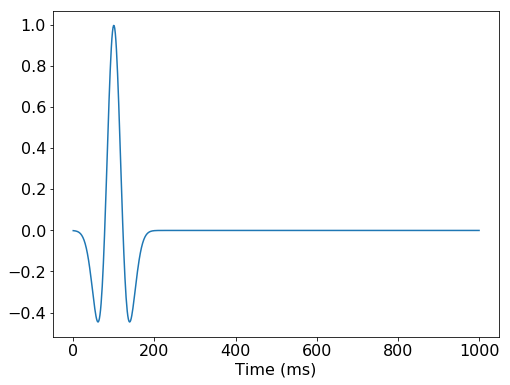

In [15]:
# NOT FOR MANUSCRIPT
plt.plot(src.time, src.data)
plt.xlabel("Time (ms)")
plt.show()

In [16]:
from examples.seismic import Receiver

# Recs are distributed across model, at depth of 20 m.
x_locs = np.linspace(0, model.domain_size[0], num=nreceivers)
rec_coords = [(980, x) for x in x_locs]

In [17]:
rec = Receiver(name='rec', npoint=nreceivers, ntime=nt,
               grid=model.grid, coordinates=rec_coords)

Now we need to generate 'real' and 'smooth' data:

In [18]:
# Compute synthetic data with forward operator 
from examples.seismic.acoustic import AcousticWaveSolver

solver = AcousticWaveSolver(model, src, rec, space_order=4)
obs , _, _ = solver.forward(src=src, m=model.m)

CustomCompiler: compiled /var/folders/8x/2cdqc7_57plfk5txbsszysbc0000gn/T/devito-c8kgx6h_/7a282d6885f4ad3a7b16fd67992b9457900f0291.c [0.21 s]
Section section_1<714,1> with OI=0.73 computed in 0.000 s [0.42 GFlops/s]
Section section_2<714,101> with OI=1.37 computed in 0.001 s [3.32 GFlops/s]
Section main<714,179,179> with OI=1.95 computed in 0.167 s [4.38 GFlops/s, 0.14 GPts/s]


In [19]:
# Compute initial data with forward operator 
pred, _, _ = solver.forward(src=src, m=model0.m)

Section section_1<714,1> with OI=0.73 computed in 0.000 s [0.20 GFlops/s]
Section section_2<714,101> with OI=1.37 computed in 0.001 s [1.82 GFlops/s]
Section main<714,179,179> with OI=1.95 computed in 0.339 s [2.16 GFlops/s, 0.07 GPts/s]


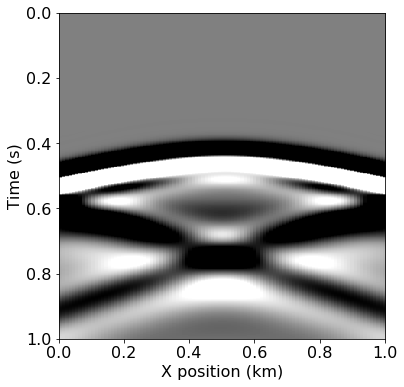

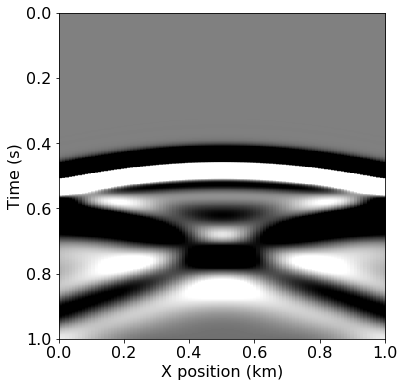

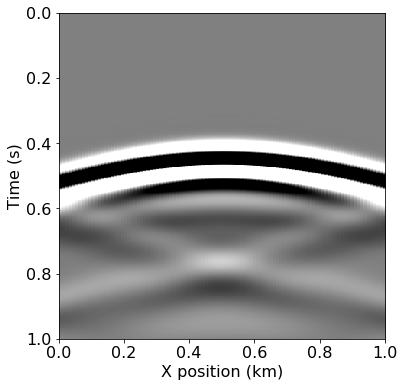

In [22]:
# Plot shot record for true and smooth velocity model and the difference
from examples.seismic import plot_shotrecord

plot_shotrecord(obs.data, model, t0, tn, colorbar=False)
plot_shotrecord(pred.data, model, t0, tn, colorbar=False)
plot_shotrecord(pred.data - obs.data, model, t0, tn, colorbar=False)

In [23]:
d_obs, d_pred = obs.data, pred.data

Finally, we create the full propagator by adding the source expression to our previously defined stencil and set the flag `time_axis=Backward`, to specify that the propagator runs in backwards in time:

In [24]:
# NOT FOR MANUSCRIPT
from devito import Operator, Backward

In [34]:
# Set up data residual.
rec.data[:] = d_pred - d_obs

# Make the adjoint src.
src_term = rec.inject(field=v.backward,
                      expr=rec * dt**2 / model.m,
                      offset=model.nbpml)

# Create the propagator.
op_adj = Operator([stencil_v] + src_term, time_axis=Backward)

In contrast to forward modeling, we do not record any measurements at the surface since we are only interested in the adjoint wavefield itself. The full script for setting up the adjoint wave equation, including an animation of the adjoint wavefield is available in **`adjoint_modeling.ipynb`**.


## Computing the FWI gradient

The goal of FWI is to estimate a discrete parametrization of the subsurface by minimizing the misfit between the observed shot records of a seismic survey and numerically modeled shot records. The predicted shot records are obtained by solving an individual wave equation per shot location and depend on the parametrization $\mathbf{m}$ of our wave propagator. The most common function for measuring the data misfit between the observed and modeled data is the $\ell_2$-norm, which leads to the following objective function (Lions (1971), Tarantola (1984)):

$$
	\mathop{\hbox{minimize}}_{\mathbf{m}} \hspace{.2cm} f(\mathbf{m})= \sum_{i=1}^{n_s} \frac{1}{2} \left\lVert \mathbf{d}^\mathrm{pred}_i (\mathbf{m}, \mathbf{q}_i) - \mathbf{d}_i^\mathrm{obs} \right\rVert_2^2,
$${#FWI}

where the index $i$ runs over the total number of shots $n_s$ and the model parameters are the squared slowness. Optimization problems of this form are called non-linear least-squares problems, since the predicted data modeled with the forward modeling propagator (`op_fwd()` in part 1) depends on the unknown parameters $\mathbf{m}$ non-linearly. The full derivation of the FWI gradient using the adjoint state method is outside the scope of this tutorial, but conceptually we obtain the gradient by applying the chain rule and taking the partial derivative of the inverse wave equation $\mathbf{A}(\mathbf{m})^{-1}$ with respect to $\mathbf{m}$, which yields the following expression (Plessix, 2006, Virieux and Operto, 2009): 

$$
 \nabla f (\mathbf{m})= -  \sum_{i=1}^{n_s}  \sum_{\text{time}=1}^{n_t} \mathbf{u}[\text{time}]\odot \ddot{\mathbf{v}}[\text{time}].
$${#FWIgrad}

The inner sum $\text{time}=1,...,n_t$ runs over the number of computational time steps $n_t$ and $\ddot{\mathbf{u}}$ denotes the second temporal derivative of the adjoint wavefield $\mathbf{u}$. Computing the gradient of Equation #FWI, therefore corresponds to performing the point-wise multiplication (denoted  by the symbol$\odot$) of the forward wavefields with the second time derivative of the adjoint wavefield and summing over all time steps.

For efficiency, the FWI gradient is calculated in the reverse time-loop while solving the adjoint wave equation as this avoids the need to also store the adjoint wavefield. Therefore, the gradient is computed on-the-fly within the reverse time loop, while updating the adjoint wavefield for the current time step $\mathbf{v}[\text{time}]$:

$$
 \mathbf{g} = \mathbf{g} - \frac{\mathbf{v}[\text{time-dt}] - 2\mathbf{v}[\text{time}] + \mathbf{v}[\text{time+dt}]}{dt^2} \odot \mathbf{u}[\text{time}], \quad \text{time}=1 \cdots n_{t-1}
$${#gradupd}

with ``\mathbf{g}`` the vector containing the gradient. The second time derivative of the adjoint wavefield is computed with a second order finite-difference stencil and uses the three adjoint wavefields that are kept in memory during the adjoint time loop (Equation #WEdisadj). To implement the FWI gradient with [Devito], we first define the gradient as a dense data object `Function`, which has no time dependence, since the gradient is computed as the sum over all time steps. The update for the gradient as defined in Equations #FWIgrad and #gradupd is then implemented in [Devito] by the following symbolic expression:

In [35]:
from devito import TimeFunction, Function

In [36]:
u = TimeFunction(name="u", grid=model.grid, 
                 time_order=2, space_order=2,
                 save=True, time_dim=nt)

In [37]:
grad = Function(name="g", grid=model.grid)
grad_update = Eq(grad, grad - u * v.dt2)

The definition of the gradient in [Devito] is straightforward and only requires to add the gradient update expression to the adjoint propagator. This yields a single symbolic expression with update instructions for both the adjoint wavefield and the gradient. The [Devito] compiler then automatically generates code with an adjoint time loop, in which the adjoint wavefield and gradient are individually updated, as defined by the symbolic expressions. Since we do not want to save the full adjoint wavefield for all time steps, we left out the flag `save=True` in the definition for the adjoint wavefield `v` (the default is `save=False`). In Python, the full expression for solving the adjoint wave equation and computing the gradient is then given by:

In [39]:
op_grad = Operator([stencil_v] + src_term + [grad_update],
                    time_axis=Backward)

Solving the adjoint wave equation by running `op_grad(time=nt, dt=model.critical_dt)` from the Python command line now includes computing the FWI gradient for a single source, which afterwards can be accessed with `grad.data`.

In [40]:
op_grad(time=nt, dt=model.critical_dt)

CustomCompiler: compiled /var/folders/8x/2cdqc7_57plfk5txbsszysbc0000gn/T/devito-c8kgx6h_/a1fe3f29bf2f847f7c5c73849a5a3f0e2612cb75.c [0.22 s]
Section section_1<714,101> with OI=0.80 computed in 0.002 s [1.79 GFlops/s]
Section main<714,180,180> with OI=2.12 computed in 0.176 s [7.90 GFlops/s, 0.13 GPts/s]


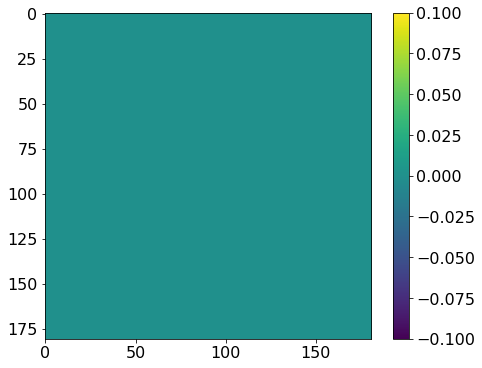

In [44]:
plt.imshow(grad.data)
plt.colorbar()
plt.show()


#### Verification

The next step of the adjoint modeling and gradient part is verification with unit testing, i.e. we ensure that the adjoints and gradients are implemented correctly. Incorrect adjoints can lead to unpredictable behaviour during and inversion and in the worst case cause slower convergence or convergence to wrong solutions. Since our forward-adjoint wave equation solvers correspond to forward-adjoint pairs, we need to ensure that the adjoint defined dot test holds within machine precision (see **`tests/test_adjointA.py`** for the dot test). Furthermore, we verify the correct implementation of the FWI gradient by ensuring that using the gradient leads to first order convergence. The gradient test can be found in **`tests/test_gradient.py`**.

#### Example

To further demonstrate the gradient computation, we perform a small seismic transmission experiment with a circular imaging phantom, i.e. a constant velocity model with a circular high velocity inclusion in its centre. For a transmission experiment, we place ``21`` seismic sources on the left-hand side of the model and ``101`` receivers on the right-hand side. We then use the forward propagator from part 1 to independently model the ``21`` "observed" shot records using the true model. As the initial model for our gradient calculation, we use a constant velocity model with the same velocity as the true model, but without the circular velocity perturbation. We then model the ``21`` predicted shot records for the initial model, calculate the data residual and gradient for each shot and sum them to obtain the full gradient (Figure #Gradient). This result can be reproduced with the notebook **`adjoint_modeling.ipynb`**.

> **Figure 1.** True velocity model, starting model and FWI gradient for 21 source locations, where each shot (red dots) is recorded by 101 receivers (green dots) located on the right-hand side of the model. The initial model used to compute the predicted data and gradient is a constant velocity model with the background velocity of the true model. This result can be reproduced by running the script **`adjoint_modeling.ipynb`**

This gradient can then be used for a simple gradient descent optimization loop, as illustrated at the end of the notebook. After each update, a new gradient is computed for the new velocity model until sufficient decrease of the objective or chosen number of iteration is reached. A detailed treatment of optimization and more advanced algorithms will be described in the third and final part of this tutorial series.

## Conclusions

The gradient of the FWI objective function is computed by solving adjoint wave equations and summing the point-wise product of forward and adjoint wavefields over all time steps. Using [Devito], the adjoint wave equation is set up in a similar fashion as the forward wave equation, with the main difference being the (adjoint) source, which is the residual between the observed and predicted shot records. The FWI gradient is computed as part of the adjoint time loop and implemented by adding its symbolic expression to the stencil for the adjoint propagator. With the ability to model shot records and compute gradients of the FWI objective function, we will demonstrate how to set up more advanced gradient-based algorithms for FWI in the next part.


## Acknowledgments

This research was carried out as part of the SINBAD II project with the support of the member organizations of the SINBAD Consortium. This work was financially supported in part by EPSRC grant EP/L000407/1 and the Imperial College London Intel Parallel Computing Centre.

## References

[1] Michael Lange, Navjot Kukreja, Mathias Louboutin, Fabio Luporini, Felippe Vieira Zacarias, Vincenzo Pandolfo, Paulius Velesko, Paulius Kazakas, and Gerard Gorman. Devito: Towards a generic finite difference DSL using symbolic python. In 6th Workshop on Python for High-Performance and Scientific Computing, pages 67–75, 11 2016. doi: 10.1109/PyHPC.2016.9.

[2] J. L. Lions. Optimal control of systems governed by partial differential equations. Springer-Verlag Berlin Heidelberg, 1st edition, 1971. ISBN 978-3-642-65026-0.

[3] Mathias Louboutin, Philipp A. Witte, Michael Lange, Navjot Kukreja, Fabio Luporini, Gerard Gorman, and Felix J. Herrmann. Full-waveform inversion - part 1: forward modeling. Submitted to The Leading Edge for the tutorial section on October 30, 2017., 2017.

[4] Aaron Meurer, Christopher P. Smith, Mateusz Paprocki, Ondřej Čertík, Sergey B. Kirpichev, Matthew Rocklin, AMiT Kumar, Sergiu Ivanov, Jason K. Moore, Sartaj Singh, Thilina Rathnayake, Sean Vig, Brian E. Granger, Richard P. Muller, Francesco Bonazzi, Harsh Gupta, Shivam Vats, Fredrik Johansson, Fabian Pedregosa, Matthew J. Curry, Andy R. Terrel, Štěpán Roučka, Ashutosh Saboo, Isuru Fernando, Sumith Kulal, Robert Cimrman, and Anthony Scopatz. Sympy: symbolic computing in python. Peer J Computer Science, 3:e103, January 2017. ISSN 2376-5992. doi: 10.7717/peerj-cs.103. URL https: //doi.org/10.7717/peerj-cs.103.


[5] R.-E. Plessix. A review of the adjoint-state method for computing the gradient of a functional with geophysical applications. Geophysical Journal International, 167(2):495, 2006. doi: 10.1111/j.1365-246X.2006.02978.x. URL +http://dx.doi.org/10.1111/j.1365-246X.2006.02978.x

[6] Albert Tarantola. Inversion of seismic reflection data in the acoustic approximation. GEOPHYSICS, 49(8): 1259–1266, 1984. doi: 10.1190/1.1441754. URL https://doi.org/10.1190/1.1441754

[7] J. Virieux and S. Operto. An overview of full-waveform inversion in exploration geophysics. GEOPHYSICS, 74 (5):WCC1–WCC26, 2009. doi: 10.1190/1.3238367. URL http://library.seg.org/doi/abs/10.1190/1.3238367

[8] Yu Zhang, Houzhu Zhang, and Guanquan Zhang. A stable tti reverse time migration and its implementation. GEOPHYSICS, 76(3):WA3–WA11, 2011. doi: 10.1190/1.3554411. URL https://doi.org/10.1190/1.3554411.

<hr> 

© 2017 The authors — licensed CC-BY-SA